In [242]:
import os
import argparse
import subprocess
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import math

### 1. Running commands

In [220]:
def run_command(cmd):
    print('\n##### Running now #####\n')
    print(cmd)
    output = subprocess.check_output(cmd, stderr=subprocess.STDOUT, shell=True)
    print('\n##### Done! #####\n')

### 2. Splitting bed file into chunks

In [221]:
def bed_file_split(bed_fn, num_chunks, tmp_path):
    '''
    Splits a bed file into even chunks and outputs each as temporary file.
    Each file has the same number of lines, except the last chunk which covers the last bit of contigs.
    Returns a list of split bed file abspaths in tmp_path.
    '''
    num_lines = 0
    with open(bed_fn, 'rb') as bed:
        for line in bed:
            num_lines += 1
    print(f'Number of lines in bedfile: {num_lines}')
    chunk_size = num_lines//num_chunks
    print(f'Target chunk size: {chunk_size}')
    
    # chop bed window file into chunks for parallel computing
    previous = 0
    files = []
    for i, chunk in enumerate([x for x in range(0, num_lines,chunk_size)]):
        if chunk == 0:
            continue
        else:
            temp_fn = os.path.join(tmp_path, f'{os.path.basename(bed_fn)}_chunk_{i-1}')
            with open(temp_fn, 'w') as temp_file:
                with open(bed_fn, 'r') as bed:
                    for line_num, line in enumerate(bed):
                        if line_num < chunk and line_num >= previous:
                            print(line.rstrip(), file=temp_file)
            previous = chunk
            files.append(temp_fn)
            
    # chunk covering the last window
    if chunk < num_lines:
        temp_fn = os.path.join(tmp_path, f'{os.path.basename(bed_fn)}_chunk_{i}')
        with open(temp_fn, 'w') as temp_file:
            with open(bed_fn, 'r') as bed:
                for line_num, line in enumerate(bed):
                    if line_num >= chunk:
                        print(line.rstrip(), file=temp_file)
    files.append(temp_fn)
    return files

### 3. Concatenating chunk samcov files into one

In [222]:
def concat_samcov(samcov_outpath, sample):
    '''
    Finds all chunk samcov files in a directory and concatenate them into one.
    samcov_path: Abs path where sample directories {timecourse}_{rep} with chunk samcov files inside are located. 
                Output directory concat_samcov will be generated here.
    sample: For specifying sample directory to be processed. e.g. GS_1, IT6_3, etc.
    '''
    samcov_list = glob.glob(os.path.join(samcov_outpath, sample, "*"))
    # sorting samcov_list in numerical order
    samcov_list = sorted(samcov_list, key=lambda x:int(x.split('samcov_')[-1]))
    
    concat_path = os.path.join(samcov_outpath, "../samcov")
    sample_path = os.path.join(concat_path, sample.split('_')[0])
    if not os.path.exists(concat_path):
        os.mkdir(concat_path)
    if not os.path.exists(sample_path):
        os.mkdir(sample_path)
    
    concat_samcov_fn = os.path.join(sample_path, os.path.basename(samcov_list[0][:-2]))
    command = f'cat {" ".join(samcov_list)} > {concat_samcov_fn}'
    run_command(command)

In [223]:
def samcov_slurp(concat_samcov_fn):
    '''
    Slurps in the concatenated samcov file.
    Calculates average coverage per base by dividing total base coverage per window by length of window in bp.
    Calculates normalised coverage in TPM.
    Returns a dataframe containing: contig, start coordinate, stop coordinate, total base coverage, average coverage per base, and normalised coverage (TPM).
    '''
    samcov_header = ["contig", "start", "stop", "total_cov"]
    df = pd.read_csv(concat_samcov_fn, sep="\t", header=None, names=samcov_header)
    df['ave_cov'] = df.total_cov/(df.stop-df.start)
    df['norm_cov'] = (df['ave_cov']/df['ave_cov'].sum())*1000000
    return df

In [224]:
def samcov_rep_mean(samcov_path):
    '''
    Calculates mean of normalised coverage across the replicates of each timecourse.
    Returns a dataframe containing: contig, start, stop, mean_norm_cov.
    '''
    file_list = glob.glob(os.path.join(samcov_path, "*"))
    
    # assure starting positions match across three reps
    allreps_start = [samcov_slurp(fn).start for fn in file_list]
    comb = combinations(range(len(file_list)), 2)
    for a,b in comb:
        pd.testing.assert_series_equal(allreps_start[a], allreps_start[b])
    info_df = samcov_slurp(file_list[0]).iloc[:,:3]
    
    # calculate mean norm cov across replicates
    allreps_norm_cov = [samcov_slurp(fn).norm_cov for fn in file_list]
    norm_cov_df = pd.concat(allreps_norm_cov,axis=1,keys=[x+1 for x in range(len(file_list))])
    norm_cov_df['mean_norm_cov'] = norm_cov_df.mean(axis=1)
    info_df['mean_norm_cov'] = norm_cov_df.mean_norm_cov
    info_df['log_mean_norm_cov'] = np.log2(info_df['mean_norm_cov'], out=np.zeros_like(info_df['mean_norm_cov']), where=(info_df['mean_norm_cov']!=0))
    return info_df

# WRAPPING UP

### 1. Generate concatenated samcov

### 2. Overlapping with kmer plots

In [227]:
date = "20210325"
genes = "genes" # I will plot against all genes so leave this unchanged
analysis_path = "/media/ssd-01/rita/kmerGWAS/kmerGWAS_analysis/"
output_path = "/media/ssd-01/rita/kmerGWAS/kmerGWAS_output/"

In [228]:
# Pst104E genome index 
fai = "/media/ssd-01/rita/kmerGWAS/kmerGWAS_analysis/20210325_analysis/Pst104EDG/Pst_104E_v13_ph_ctg.fa.fai"

# coeffector gene model
coef_gb = "/media/ssd-01/rita/kmerGWAS/kmerGWAS_analysis/20210325_analysis/Pst104EDG/sorted_gene_beds/coeffectors.gene.bed"
secre_gb = "/media/ssd-01/rita/kmerGWAS/kmerGWAS_analysis/20210325_analysis/Pst104EDG/sorted_gene_beds/secretome.gene.bed"
gene_gb = "/media/ssd-01/rita/kmerGWAS/kmerGWAS_analysis/20210325_analysis/Pst104EDG/sorted_gene_beds/genes.gene.bed"

In [229]:
def make_table(Yr, date):
    bed_file = os.path.join(analysis_path, f'{date}_analysis/{Yr}/kmer_mapping/pulled_kmers/{genes}/Pst104EDG_{Yr}_{genes}_kmers.align.intersect')
    kmer_file = os.path.join(output_path, f'{date}/{Yr}/gwas_results/kmers/pass_threshold_5per')
    
    bed_df = pd.read_csv(bed_file, sep="\t", usecols=[0,1,2,3,4], names=["contig","start","stop","kmer_name","locus_tag"])
    p_value = pd.read_csv(kmer_file, sep="\t").iloc[:,-1]
    p_value.index += 1
    
    bed_df["p_value"] = [p_value[i] for i in [int(k_name.split("kmer")[-1]) for k_name in bed_df["kmer_name"]]]
    bed_df["log_p"] = -(np.log(bed_df["p_value"])/np.log(10))
    bed_df["start"]= bed_df["start"]/1000     #only map start coordinates in kb
    return bed_df

In [230]:
def draw_plots(Yr, date, fai, coef_gb, secre_gb, gene_gb, concat_samcov_path, timecourse, boundary, svg_dir_name=None):
    kmer_df = make_table(Yr, date)
    threshold = 0.05*len(kmer_df["contig"])
    # retain contigs with at least 5% kmers hit
    contigs = [c for c,n in kmer_df["contig"].value_counts().to_dict().items() if n>=threshold]
    
    fai_df = pd.read_csv(fai, sep="\t", usecols=[0,1], names=["contig","length"])
    coef_gb_df = pd.read_csv(coef_gb, sep="\t", usecols=[0,1,2,3], names=["contig","start","end","name"])
    secre_gb_df = pd.read_csv(secre_gb, sep="\t", usecols=[0,1,2,3], names=["contig","start","end","name"])
    genes_gb_df = pd.read_csv(gene_gb, sep="\t", usecols=[0,1,2,3], names=["contig","start","end","name"])
    
    # index every pulled contig after it for creating canvas for tracks
    tags = [b for a in zip(contigs,range(len(contigs))) for b in a]
    fig, ax = plt.subplots(nrows=len(tags), ncols=1, figsize=(12,7*len(contigs)), gridspec_kw={'height_ratios': [3,1]*int(len(contigs))})
    
    for i,c in enumerate(tags):
        if type(c) == str:
            subset = kmer_df[kmer_df["contig"] == c]
            x = subset["start"].to_numpy()
            y = subset["log_p"].to_numpy()
            
            print(f'\n ============================== {c} ==============================')
            find_locus_tag(subset, coef_gb_df, secre_gb_df, genes_gb_df, show_kmers=False)
            
            if boundary == "zoom_in":
                # NEEDS CHANGE - zoom in regions (20kb window) to site with >5% kmer hit
                left = min(subset["start"])-0.3*min(subset["start"])
                right = max(subset["start"])+0.3*max(subset["start"])
            elif boundary == "whole":
                left = 0
                right = int(fai_df[fai_df["contig"] == c]["length"])/1000
            
            ax[i].set(xlim=(left,right))
            ax[i].set_title(f'Association mapping against PST104E {c} using k-mers', fontsize=14, fontweight="bold")
            ax[i].set_xlabel("position(kb)", fontsize=14)
            ax[i].set_ylabel("-log10[p-value]", fontsize=14)
            ax[i].scatter(x, y, s=10, color="k", alpha=0.2)
            ax[i].annotate(f'n = {len(y)}', xy=(625,230), xycoords="axes points")
            # 'xycoords' defines coordinate system so xy are in canvas units instead of dataset so 'n=...' textbox has a fixed location
            # size = fig.get_size_inches()*fig.dpi
            
            # IT6 vs IT9
            if timecourse == "IT":
                samcov_df_IT6 = samcov_rep_mean(os.path.join(concat_samcov_path, "IT6"))
                samcov_contig_df_IT6 = samcov_df_IT6[samcov_df_IT6.contig == c]
                samcov_df_IT9 = samcov_rep_mean(os.path.join(concat_samcov_path, "IT9"))
                samcov_contig_df_IT9 = samcov_df_IT9[samcov_df_IT9.contig == c]
                samcov_df_HE = samcov_rep_mean(os.path.join(concat_samcov_path, "HE"))
                samcov_contig_df_HE = samcov_df_HE[samcov_df_HE.contig == c]
                cov_pf_IT6 = ax[i].twinx()
                cov_pf_IT9 = ax[i].twinx()
                cov_pf_HE = ax[i].twinx()
                cov_pf_IT6.set_ylabel("log2[mean normd per-base cov]", fontsize=14)

                ylim = max(1.1*samcov_contig_df_IT6.log_mean_norm_cov.describe()[-1], 1.1*samcov_contig_df_IT9.log_mean_norm_cov.describe()[-1], 1.1*samcov_contig_df_HE.log_mean_norm_cov.describe()[-1])
                plot_IT6, = cov_pf_IT6.plot(samcov_contig_df_IT6.start/1000, samcov_contig_df_IT6.log_mean_norm_cov, alpha=0.5, color='blue')
                plot_IT9, = cov_pf_IT9.plot(samcov_contig_df_IT9.start/1000, samcov_contig_df_IT9.log_mean_norm_cov, alpha=0.5, color='red')
                plot_HE, = cov_pf_HE.plot(samcov_contig_df_HE.start/1000, samcov_contig_df_HE.log_mean_norm_cov, alpha=0.4, color='orange')
                
                cov_pf_IT6.set_ylim(0, ylim)
                cov_pf_IT9.set_ylim(0, ylim)
                cov_pf_HE.set_ylim(0, ylim)
                    
                cov_pf_IT6.legend(handles=[plot_IT6, plot_IT9, plot_HE],
                                labels=["IT6","IT9", "HE"],
                                loc="upper left")
                cov_pf_IT9.axis('off')
                cov_pf_HE.axis('off')
            
                
            # all
            elif timecourse == "all":
                samcov_df_IT6 = samcov_rep_mean(os.path.join(concat_samcov_path, "IT6"))
                samcov_contig_df_IT6 = samcov_df_IT6[samcov_df_IT6.contig == c]
                samcov_df_IT9 = samcov_rep_mean(os.path.join(concat_samcov_path, "IT9"))
                samcov_contig_df_IT9 = samcov_df_IT9[samcov_df_IT9.contig == c]
                samcov_df_UG = samcov_rep_mean(os.path.join(concat_samcov_path, "UG"))
                samcov_contig_df_UG = samcov_df_UG[samcov_df_UG.contig == c]
                samcov_df_HE = samcov_rep_mean(os.path.join(concat_samcov_path, "HE"))
                samcov_contig_df_HE = samcov_df_HE[samcov_df_HE.contig == c]
                samcov_df_GS = samcov_rep_mean(os.path.join(concat_samcov_path, "GS"))
                samcov_contig_df_GS = samcov_df_GS[samcov_df_GS.contig == c]
                cov_pf_IT6 = ax[i].twinx()
                cov_pf_IT9 = ax[i].twinx()
                cov_pf_UG = ax[i].twinx()
                cov_pf_HE = ax[i].twinx()
                cov_pf_GS = ax[i].twinx()
                cov_pf_IT6.set_ylabel("mean normalised cov per base", fontsize=14)

                ylim = max(1.1*samcov_contig_df_IT6.log_mean_norm_cov.describe()[-1], 1.1*samcov_contig_df_IT9.log_mean_norm_cov.describe()[-1],
                          1.1*samcov_contig_df_UG.log_mean_norm_cov.describe()[-1], 1.1*samcov_contig_df_HE.log_mean_norm_cov.describe()[-1],
                          1.1*samcov_contig_df_GS.log_mean_norm_cov.describe()[-1])
                plot_IT6, = cov_pf_IT6.plot(samcov_contig_df_IT6.start/1000, samcov_contig_df_IT6.log_mean_norm_cov, alpha=0.5, color='blue')
                plot_IT9, = cov_pf_IT9.plot(samcov_contig_df_IT9.start/1000, samcov_contig_df_IT9.log_mean_norm_cov, alpha=0.5, color='red')
                plot_UG, = cov_pf_UG.plot(samcov_contig_df_UG.start/1000, samcov_contig_df_UG.log_mean_norm_cov, alpha=0.4, color='seagreen')
                plot_HE, = cov_pf_HE.plot(samcov_contig_df_HE.start/1000, samcov_contig_df_HE.log_mean_norm_cov, alpha=0.4, color='orange')
                plot_GS, = cov_pf_GS.plot(samcov_contig_df_GS.start/1000, samcov_contig_df_GS.log_mean_norm_cov, alpha=0.4, color='darkmagenta')

                cov_pf_IT6.set_ylim(0, ylim)
                cov_pf_IT9.set_ylim(0, ylim)
                cov_pf_UG.set_ylim(0, ylim)
                cov_pf_HE.set_ylim(0, ylim)
                cov_pf_GS.set_ylim(0, ylim)

                cov_pf_IT6.legend(handles=[plot_IT6, plot_IT9, plot_UG, plot_HE, plot_GS],
                                 labels=["IT6","IT9","UG","HE","GS"],
                                 loc="upper left")
                cov_pf_IT9.axis('off')
                cov_pf_UG.axis('off')
                cov_pf_HE.axis('off')
                cov_pf_GS.axis('off')
            
            # coeffector gene bed
            coef_subset = coef_gb_df[coef_gb_df["contig"] == c]
            coef_start = np.unique(coef_subset["start"].to_numpy()/1000)
            coef_end = np.unique(coef_subset["end"].to_numpy()/1000)
            
            # secretome gene bed
            secre_subset = secre_gb_df[secre_gb_df["contig"] == c]
            secre_start = np.unique(secre_subset["start"].to_numpy()/1000)
            secre_end = np.unique(secre_subset["end"].to_numpy()/1000)
            
            # genes gene bed
            genes_subset = genes_gb_df[genes_gb_df["contig"] == c]
            genes_start = np.unique(genes_subset["start"].to_numpy()/1000)
            genes_end = np.unique(genes_subset["end"].to_numpy()/1000)
        else:
            ax[i].set(xlim=(left,right), ylim=(0.8,1.6))
            ax[i].axis("off")
            ax[i].hlines(xmin=coef_start, xmax=coef_end, y=[1.4]*len(coef_start), color="r", lw=5, label="coeffectors")
            ax[i].hlines(xmin=secre_start, xmax=secre_end, y=[1.2]*len(secre_start), color="b", lw=5, label="secretomes")
            ax[i].hlines(xmin=genes_start, xmax=genes_end, y=[1]*len(genes_start), color="g", lw=5, label="all genes")
            ax[i].legend(bbox_to_anchor = (-0.06,0.96), loc = 'upper center', 
                         frameon=False, labelspacing=1.08, handlelength=0, handletextpad=0) # last two options to remove legend markers
            
    if svg_dir_name != None:
        svg_path = os.path.join(concat_samcov_path, "..", svg_dir_name, Yr)
        if not os.path.exists(svg_path):
            os.makedirs(svg_path)
        if boundary == "zoom_in":
            fig.savefig(os.path.join(svg_path, f"{Yr}_{timecourse}_z.svg"))
        elif boundary == "whole":
            fig.savefig(os.path.join(svg_path, f"{Yr}_{timecourse}_w.svg"))

In [243]:
def find_locus_tag(subset, coef_gb_df, secre_gb_df, genes_gb_df, show_kmers=False):
    locus_id = subset["locus_tag"].value_counts().index.tolist()
    
    for tag in locus_id:
        assert tag in genes_gb_df["name"].tolist()
        if tag in secre_gb_df["name"].tolist():
            if tag in coef_gb_df["name"].tolist():
                print(f'\nLocus id: {tag} (coeffector)')
            else:
                print(f'\nLocus id: {tag} (secretome)')
        else:
            print(f'\nLocus id: {tag}')
            
        coord_list = [int(start*1000) for start in subset[subset["locus_tag"] == tag]["start"].tolist()]
        num_kmer_threshold = len(subset)*0.05
        print(f'Number of k-mers mapped to the position: {len(coord_list)}')
        if len(coord_list) <= num_kmer_threshold:
            print('*** k-mer hit lower than 5% ***')
        if show_kmers == True:
            print(f'Start position of k-mers: {coord_list}')
        print(f'Mean position of k-mers: {round(sum(coord_list)/len(coord_list), 2)}\n')

In [244]:
def output_svg_plots(Yr, condition, boundary, svg_dir_name=None):
    if type(Yr) == list:
        for y in Yr:
            draw_plots(y, date, fai, coef_gb, secre_gb, gene_gb, concat_path, condition, boundary, svg_dir_name)
    else:
        draw_plots(Yr, date, fai, coef_gb, secre_gb, gene_gb, concat_path, condition, boundary, svg_dir_name)

# **=========== Plots ===========**
**IMPORTANT: The plots generated in jupyter browser can be misleading due to poor rendering. Output plots should be generated in .svg format for high resolution.**

## **Output plots for all possible Yr genes**

## **Yr6**

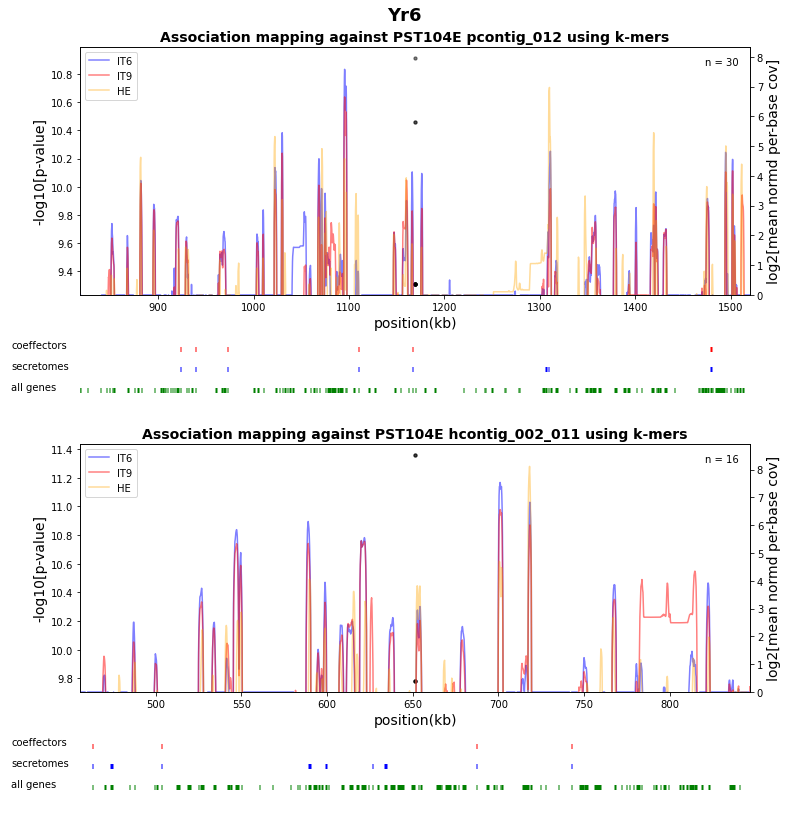

In [203]:
draw_plots("Yr6", date, fai, coef_gb, secre_gb, gene_gb, concat_path, timecourse="IT", boundary="zoom_in")

## **Yr7**

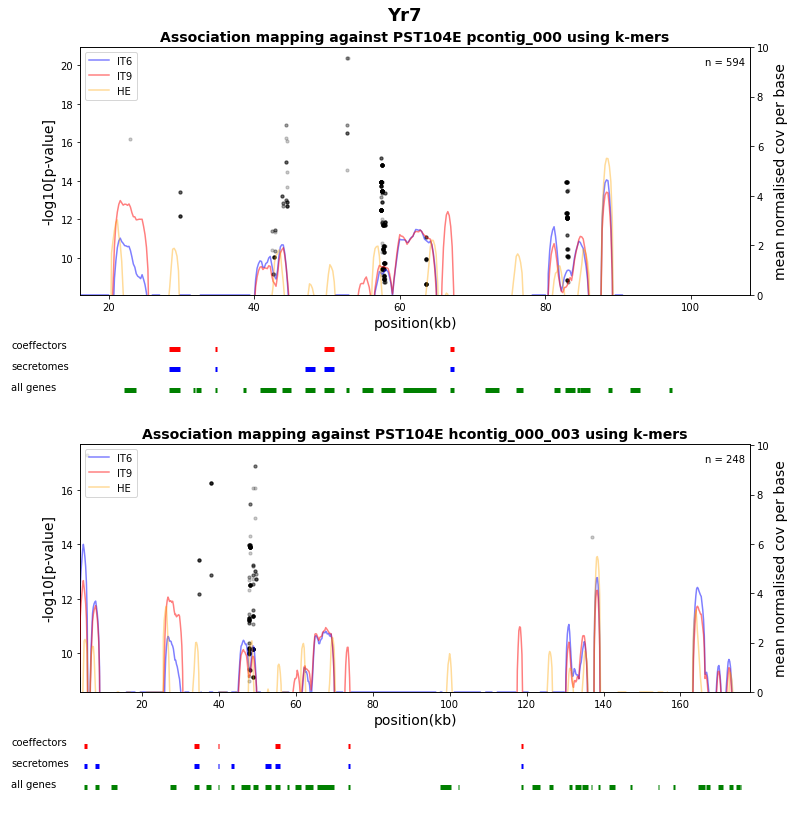

In [195]:
draw_plots("Yr7", date, fai, coef_gb, secre_gb, gene_gb, concat_path, timecourse="IT", boundary="zoom_in")

## **Yr8**

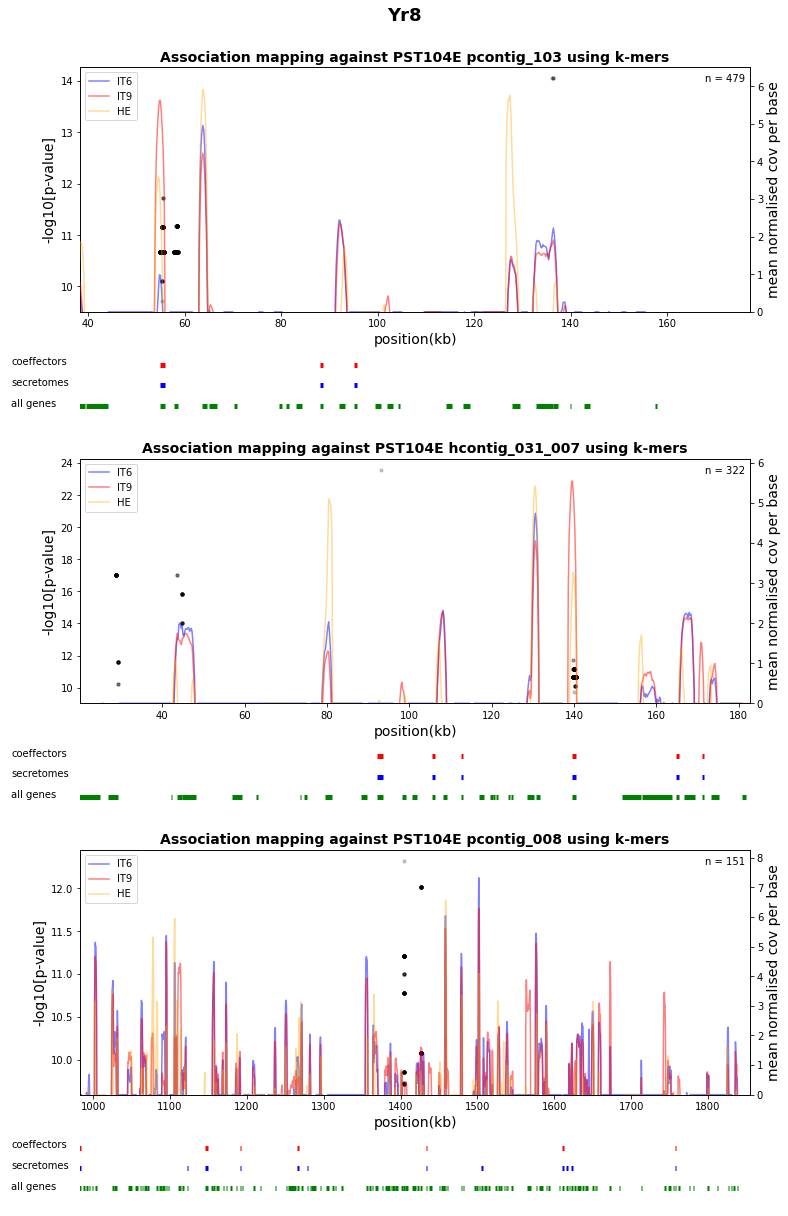

In [196]:
draw_plots("Yr8", date, fai, coef_gb, secre_gb, gene_gb, concat_path, timecourse="IT", boundary="zoom_in")

## **Yr9**

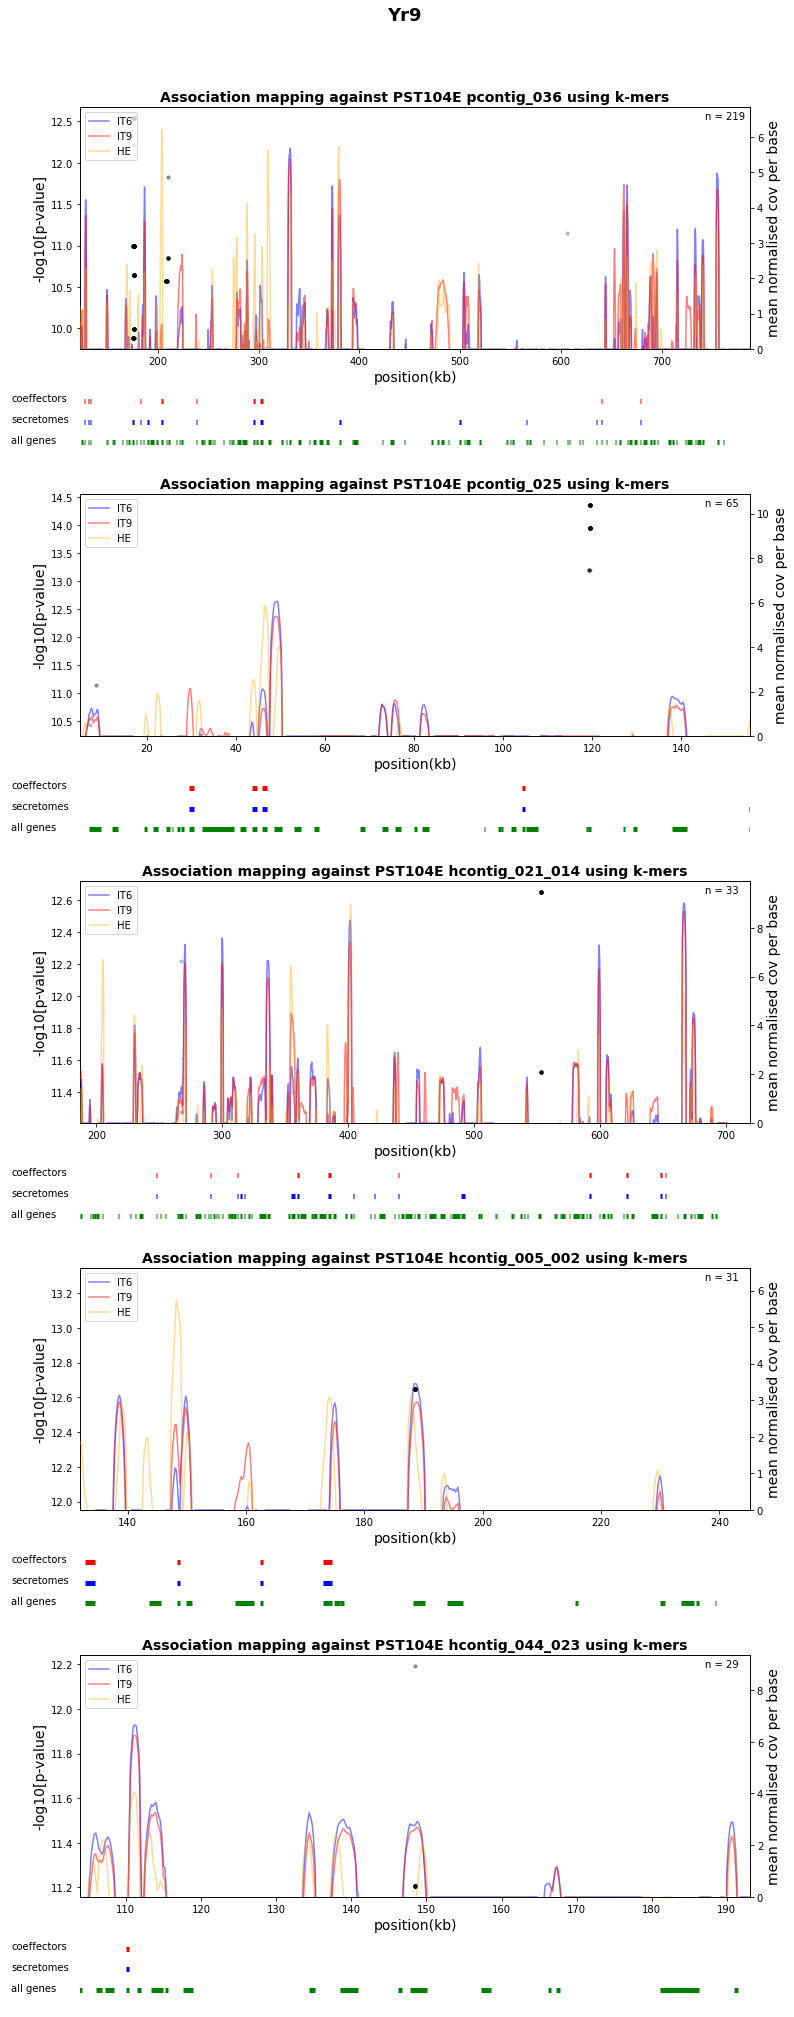

In [197]:
draw_plots("Yr9", date, fai, coef_gb, secre_gb, gene_gb, concat_path, timecourse="IT", boundary="zoom_in")

## **Yr43**

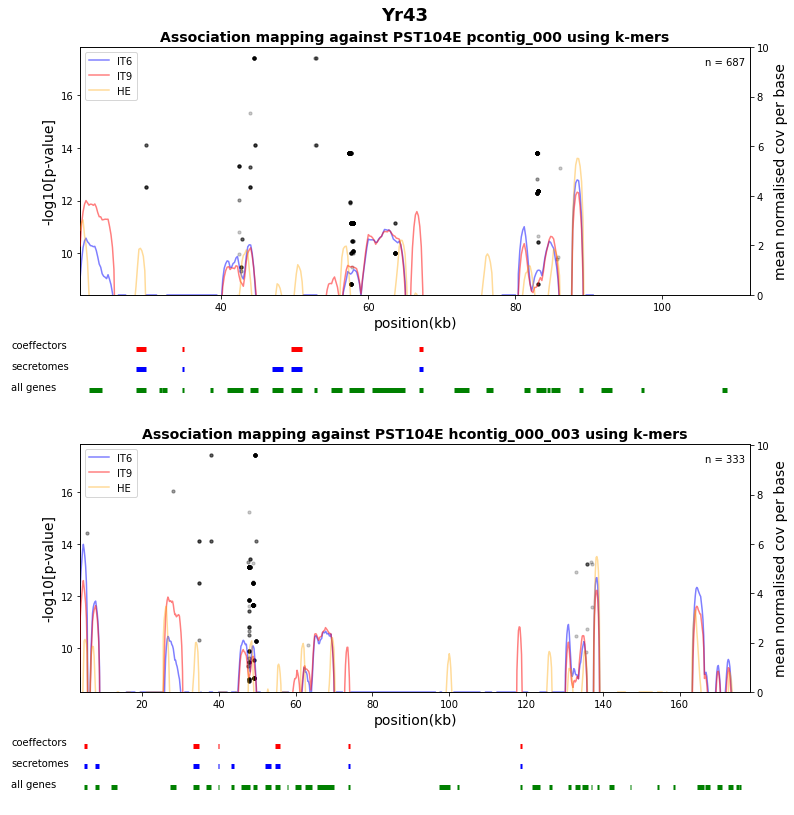

In [198]:
draw_plots("Yr43", date, fai, coef_gb, secre_gb, gene_gb, concat_path, timecourse="IT", boundary="zoom_in")